<h1 style="text-align: center" >Stock Price Prediction</h1>

## Import Libraries

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

## Functions

### Preprocessing

In [2]:
def preprocess_data(df, days_ahead=30, window_size=30):
    df["Label"] = df["Close"].shift(-days_ahead)
    df["30_day_moving_average"] = df["Close"].rolling(window=window_size).mean()

    df.dropna(inplace=True)
    return df

### Load Data

In [3]:
def load_data(stock):
    stock = stock.upper()
    df = pd.read_csv(f"nasdaq/{stock}.csv", parse_dates=["Date"], dayfirst=True)
    df = preprocess_data(df)
    df.index = df.pop("Date")
    return df

### Split Data

In [4]:
def split_data(X, y, test_ratio=0.1, val_ratio=0.1):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_ratio + val_ratio, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_ratio / (test_ratio + val_ratio), shuffle=False 
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

### LSTM Functions

In [5]:
def df_to_windowed_df(df, n=3):
    last_date = df.index.max()
    target_date = df.index[n]

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = df.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f"Error: Window of size {n} is too large for date {target_date}")
            return

        values = df_subset["Close"].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date : target_date + datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split("T")[0]
        year_month_day = next_date_str.split("-")
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df["Target Date"] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f"Target-{n-i}"] = X[:, i]

    ret_df["Target"] = Y

    return ret_df

In [6]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
  
    dates = df_as_np[:, 0]
  
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  
    Y = df_as_np[:, -1]
  
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Train and Test Models

In [7]:
# initialize dictionary of lists to keep track of scores
amzn_scores = {}
aal_scores = {}
aapl_scores = {}
msft_scores = {}
nvda_scores = {}

## Amazon Dataframe

In [8]:
df = load_data("AMZN")

In [9]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1997-06-26,0.075260,0.076042,63792000,0.076042,0.075521,0.075521,0.114583,0.077891
1997-06-27,0.073958,0.075781,23760000,0.075781,0.074479,0.074479,0.116406,0.077109
1997-06-30,0.073958,0.075521,54936000,0.079948,0.077083,0.077083,0.109896,0.076797
1997-07-01,0.075521,0.077083,25848000,0.077083,0.075781,0.075781,0.109896,0.076476
1997-07-02,0.075521,0.075781,77640000,0.079688,0.079427,0.079427,0.107813,0.076398
...,...,...,...,...,...,...,...,...
2022-10-24,116.570000,119.980003,49531500,120.389999,119.820000,119.820000,88.250000,117.587667
2022-10-25,118.949997,119.650002,50934600,121.320000,120.599998,120.599998,88.459999,117.380333
2022-10-26,114.760002,116.000000,68802300,119.349998,115.660004,115.660004,90.349998,116.950667


Text(0.5, 1.0, 'Close Prices Over Time')

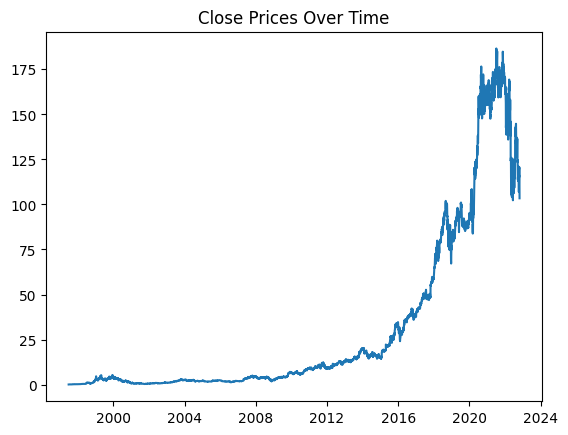

In [10]:
plt.plot(df.index, df['Close'])
plt.title("Close Prices Over Time")

In [11]:
X = df.drop(columns="Label")
y = df["Label"]

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

#### Training

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [15]:
train_pred = lr.predict(X_train).flatten()
val_pred = lr.predict(X_val).flatten()
test_pred = lr.predict(X_test).flatten()

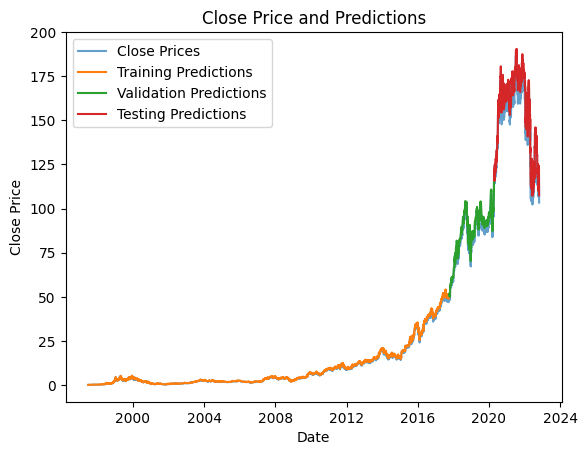

In [16]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [17]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
amzn_scores["lr"] = results

Train Score: 1.31 RMSE
Cross Validation Score: 8.68 RMSE
Test Score: 18.05 RMSE


### Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor

#### Training

In [19]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [20]:
train_pred = rf.predict(X_train).flatten()
val_pred = rf.predict(X_val).flatten()
test_pred = rf.predict(X_test).flatten()

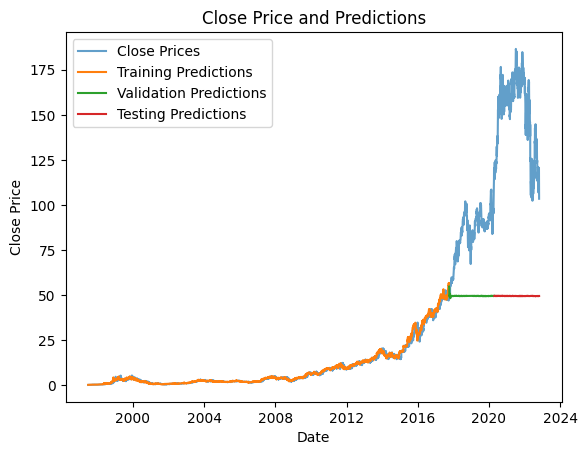

In [21]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [22]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
amzn_scores["rf"] = results

Train Score: 0.26 RMSE
Cross Validation Score: 40.33 RMSE
Test Score: 103.07 RMSE


### Support Vector Machine

In [23]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#### Training

In [24]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [25]:
svm = SVR(kernel="linear", C=1)
svm.fit(X_train_scaled, y_train)

SVR(C=1, kernel='linear')

#### Results

In [26]:
train_pred = svm.predict(X_train_scaled).flatten()
val_pred = svm.predict(X_val_scaled).flatten()
test_pred = svm.predict(X_test_scaled).flatten()

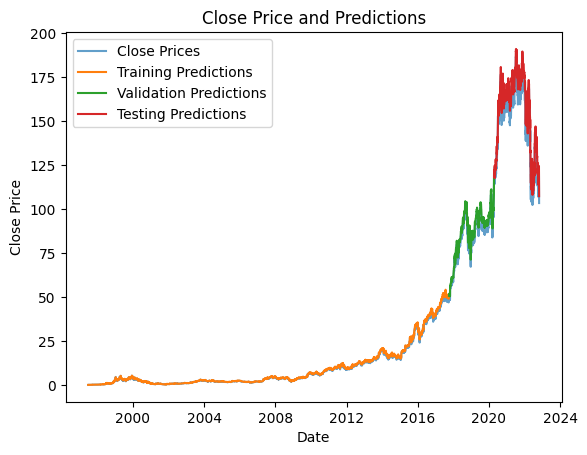

In [27]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [28]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
amzn_scores["svm"] = results

Train Score: 1.31 RMSE
Cross Validation Score: 8.66 RMSE
Test Score: 18.29 RMSE


### LSTM

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2023-04-30 21:22:18.035685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 21:22:18.103758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-30 21:22:18.103772: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-30 21:22:18.565603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

#### Training

In [30]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1997-07-01,0.075521,0.074479,0.077083,0.075781
1,1997-07-02,0.074479,0.077083,0.075781,0.079427
2,1997-07-03,0.077083,0.075781,0.079427,0.095573
3,1997-07-07,0.075781,0.079427,0.095573,0.100000
4,1997-07-08,0.079427,0.095573,0.100000,0.115104
...,...,...,...,...,...
6371,2022-10-24,115.070000,115.250000,119.320000,119.820000
6372,2022-10-25,115.250000,119.320000,119.820000,120.599998
6373,2022-10-26,119.320000,119.820000,120.599998,115.660004
6374,2022-10-27,119.820000,120.599998,115.660004,110.959999


In [31]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
# dates.shape, X.shape, y.shape
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [32]:
dates_train = dates[: len(X_train)]
dates_val = dates[len(X_train) : len(X_train) + len(X_val)]
dates_test = dates[len(X_train) + len(X_val) :]

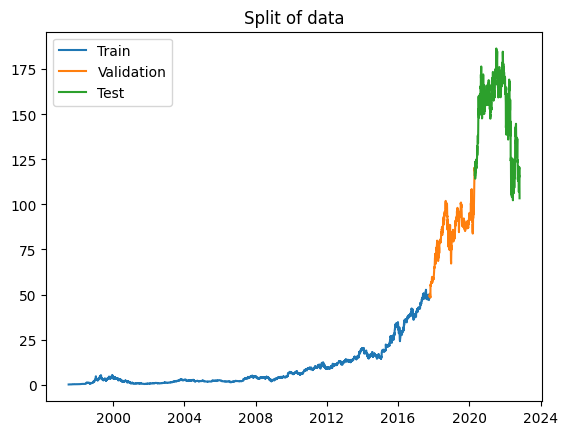

In [33]:
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test")
plt.title("Split of data")
plt.legend()

In [34]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100


2023-04-30 21:22:20.783231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 21:22:20.783404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-30 21:22:20.783443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-30 21:22:20.783477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-30 21:22:20.783510: W tensorflow/c

160/160 [==============================] - 2s 4ms/step - loss: 77.2843 - mean_absolute_error: 3.8194 - val_loss: 1444.3475 - val_mean_absolute_error: 35.7521
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1515 - mean_absolute_error: 0.2008 - val_loss: 1150.0896 - val_mean_absolute_error: 31.4520
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0918 - mean_absolute_error: 0.1678 - val_loss: 1089.9318 - val_mean_absolute_error: 30.5131
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0839 - mean_absolute_error: 0.1633 - val_loss: 1069.1969 - val_mean_absolute_error: 30.1965
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0827 - mean_absolute_error: 0.1576 - val_loss: 1048.3613 - val_mean_absolute_error: 29.8682
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0884 - mean_absolute_error: 0.1654 - val_loss: 1034.5410 - val_mean_absolute_error: 29.63

#### Results

20/20 [==============================] - 0s 678us/step


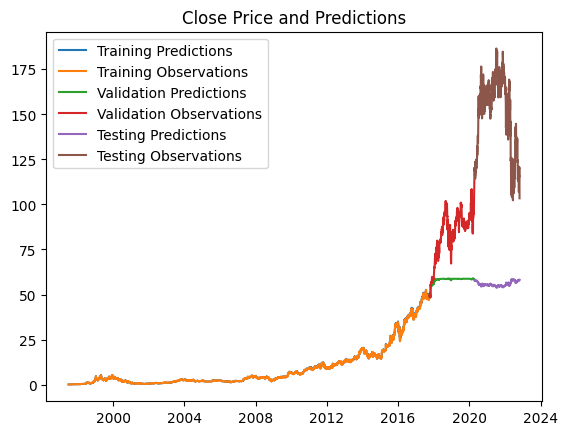

In [35]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")

# validation data
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")

# testing data
plt.plot(dates_test, test_pred, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")

plt.title("Close Price and Predictions")
plt.legend()
plt.show()

In [36]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
amzn_scores["lstm"] = results

Train Score: 0.27 RMSE
Cross Validation Score: 28.87 RMSE
Test Score: 97.71 RMSE


In [37]:
amzn_scores

{'lr': [1.3066756330659544, 8.684258042986047, 18.049148749123855],
 'rf': [0.2552041960579979, 40.3270890912664, 103.06557299434472],
 'svm': [1.3087238552888387, 8.655824310240376, 18.28902523482942],
 'lstm': [0.27149323, 28.868366, 97.71498]}

## American Airlines Dataframe

In [38]:
df = load_data("AAL")

In [39]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
2005-11-07,28.379999,29.000000,486900,29.430000,28.930000,27.273512,35.320000,22.847000
2005-11-08,29.000000,29.100000,1395000,29.700001,29.430000,27.744884,36.509998,23.184667
2005-11-09,29.430000,29.430000,1312300,31.299999,31.299999,29.507811,36.830002,23.544666
2005-11-10,31.150000,31.150000,1948900,33.959999,32.799999,30.921915,37.730000,23.964333
2005-11-11,33.000000,33.049999,1183900,33.950001,33.349998,31.440432,37.459999,24.375666
...,...,...,...,...,...,...,...,...
2022-10-24,13.590000,13.750000,32811000,14.120000,14.100000,14.100000,14.330000,13.040333
2022-10-25,13.930000,14.050000,27677200,14.370000,14.290000,14.290000,13.550000,13.060667
2022-10-26,13.990000,14.140000,28273700,14.440000,14.000000,14.000000,13.600000,13.059667


Text(0.5, 1.0, 'Close Prices Over Time')

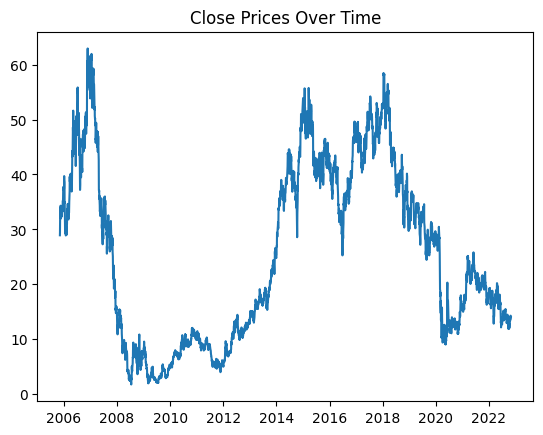

In [40]:
plt.plot(df.index, df['Close'])
plt.title("Close Prices Over Time")

In [41]:
X = df.drop(columns="Label")
y = df["Label"]

In [42]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Linear Regression

#### Training

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [44]:
train_pred = lr.predict(X_train).flatten()
val_pred = lr.predict(X_val).flatten()
test_pred = lr.predict(X_test).flatten()

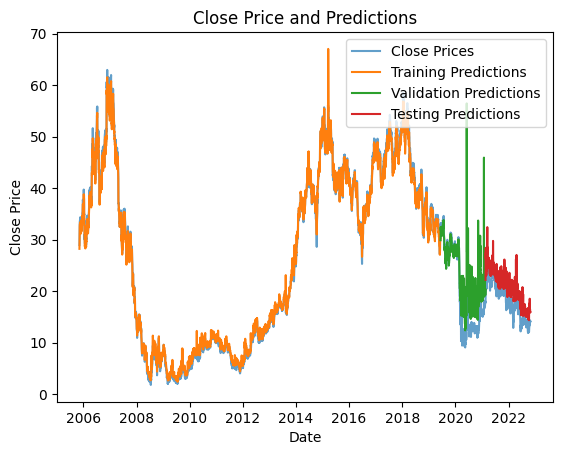

In [45]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [46]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aal_scores["lr"] = results

Train Score: 4.31 RMSE
Cross Validation Score: 7.42 RMSE
Test Score: 3.71 RMSE


### Random Forest Regressor

#### Training

In [47]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [48]:
train_pred = rf.predict(X_train).flatten()
val_pred = rf.predict(X_val).flatten()
test_pred = rf.predict(X_test).flatten()

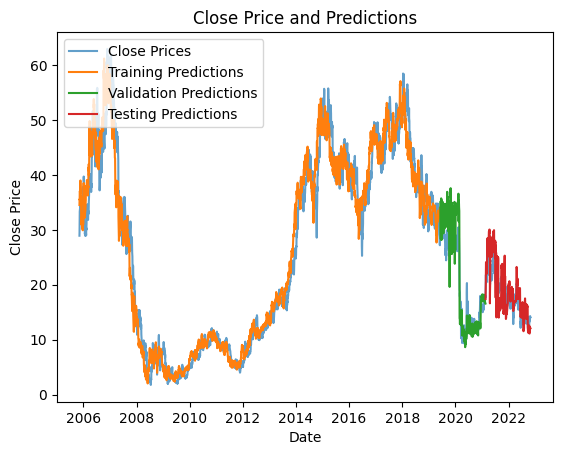

In [49]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [50]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aal_scores["rf"] = results

Train Score: 1.10 RMSE
Cross Validation Score: 6.77 RMSE
Test Score: 4.06 RMSE


### Support Vector Machine

#### Training

In [51]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [52]:
svm = SVR(kernel="linear", C=1)
svm.fit(X_train_scaled, y_train)

SVR(C=1, kernel='linear')

#### Results

In [53]:
train_pred = svm.predict(X_train_scaled).flatten()
val_pred = svm.predict(X_val_scaled).flatten()
test_pred = svm.predict(X_test_scaled).flatten()

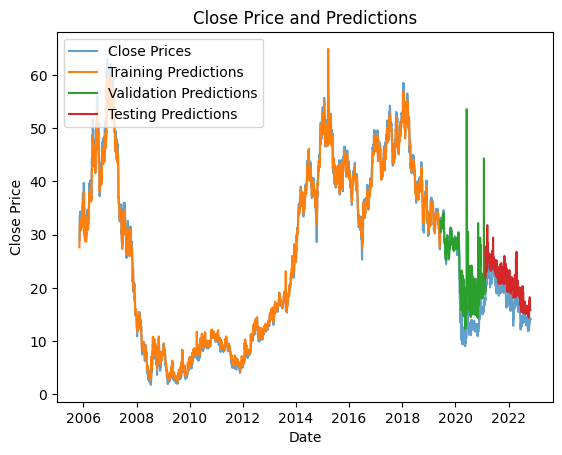

In [54]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [55]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aal_scores["svm"] = results

Train Score: 4.33 RMSE
Cross Validation Score: 7.25 RMSE
Test Score: 3.76 RMSE


### LSTM

#### Training

In [56]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2005-11-10,28.930000,29.430000,31.299999,32.799999
1,2005-11-11,29.430000,31.299999,32.799999,33.349998
2,2005-11-14,31.299999,32.799999,33.349998,33.750000
3,2005-11-15,32.799999,33.349998,33.750000,33.880001
4,2005-11-16,33.349998,33.750000,33.880001,33.599998
...,...,...,...,...,...
4266,2022-10-24,13.990000,13.460000,13.710000,14.100000
4267,2022-10-25,13.460000,13.710000,14.100000,14.290000
4268,2022-10-26,13.710000,14.100000,14.290000,14.000000
4269,2022-10-27,14.100000,14.290000,14.000000,13.970000


In [57]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
# dates.shape, X.shape, y.shape
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [58]:
dates_train = dates[: len(X_train)]
dates_val = dates[len(X_train) : len(X_train) + len(X_val)]
dates_test = dates[len(X_train) + len(X_val) :]

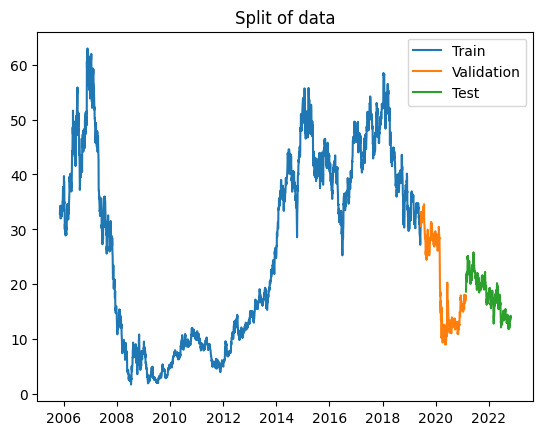

In [59]:
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test")
plt.title("Split of data")
plt.legend()

In [60]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
107/107 [==============================] - 2s 5ms/step - loss: 771.5815 - mean_absolute_error: 22.3889 - val_loss: 27.2193 - val_mean_absolute_error: 4.3797
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: 10.1850 - mean_absolute_error: 1.5747 - val_loss: 0.7337 - val_mean_absolute_error: 0.6104
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 0.9666 - mean_absolute_error: 0.6510 - val_loss: 0.7165 - val_mean_absolute_error: 0.5992
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 0.8474 - mean_absolute_error: 0.6291 - val_loss: 0.8101 - val_mean_absolute_error: 0.6468
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 0.8675 - mean_absolute_error: 0.6444 - val_loss: 1.1451 - val_mean_absolute_error: 0.8195
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 0.8025 - mean_absolute_error: 0.6116 - val_loss: 0.7921 - val_mean_absolute_error: 0.6333
Epoch

#### Results

14/14 [==============================] - 0s 782us/step


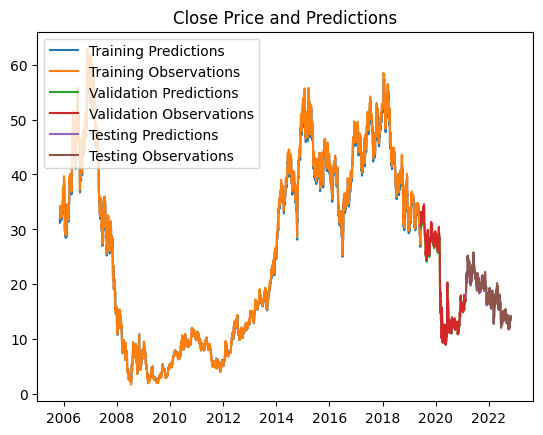

In [61]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")

# validation data
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")

# testing data
plt.plot(dates_test, test_pred, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")

plt.title("Close Price and Predictions")
plt.legend()
plt.show()

In [62]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aal_scores["lstm"] = results

Train Score: 0.92 RMSE
Cross Validation Score: 0.82 RMSE
Test Score: 0.61 RMSE


In [63]:
aal_scores

{'lr': [4.311301040256385, 7.418295691383942, 3.7072570042613617],
 'rf': [1.1022086096343575, 6.7661975348862065, 4.064471815714501],
 'svm': [4.327837289950504, 7.245699450135821, 3.7633889981402477],
 'lstm': [0.9225317, 0.81813926, 0.6110661]}

## Apple Dataframe

In [64]:
df = load_data("AAPL")

In [65]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1981-01-26,0.143973,0.144531,24640000,0.144531,0.143973,0.112032,0.100446,0.139788
1981-01-27,0.142857,0.143973,23699200,0.143973,0.142857,0.111164,0.096540,0.140272
1981-01-28,0.138393,0.138951,28156800,0.138951,0.138393,0.107690,0.100446,0.140830
1981-01-29,0.133371,0.133929,43904000,0.133929,0.133371,0.103782,0.099330,0.141518
1981-01-30,0.126116,0.127232,46188800,0.127232,0.126116,0.098137,0.103237,0.141871
...,...,...,...,...,...,...,...,...
2022-10-24,146.000000,147.190002,75981900,150.229996,149.449997,149.202484,142.910004,146.774998
2022-10-25,149.360001,150.089996,74732300,152.490005,152.339996,152.087708,140.940002,146.724998
2022-10-26,148.039993,150.960007,88194300,151.990005,149.350006,149.102661,142.649994,146.526332


Text(0.5, 1.0, 'Close Prices Over Time')

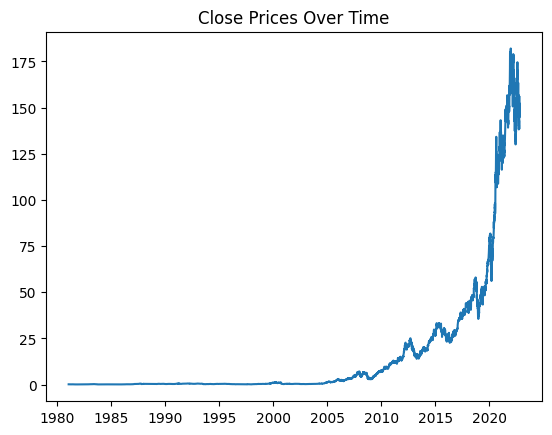

In [66]:
plt.plot(df.index, df['Close'])
plt.title("Close Prices Over Time")

In [67]:
X = df.drop(columns="Label")
y = df["Label"]

In [68]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Linear Regression

#### Training

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [70]:
train_pred = lr.predict(X_train).flatten()
val_pred = lr.predict(X_val).flatten()
test_pred = lr.predict(X_test).flatten()

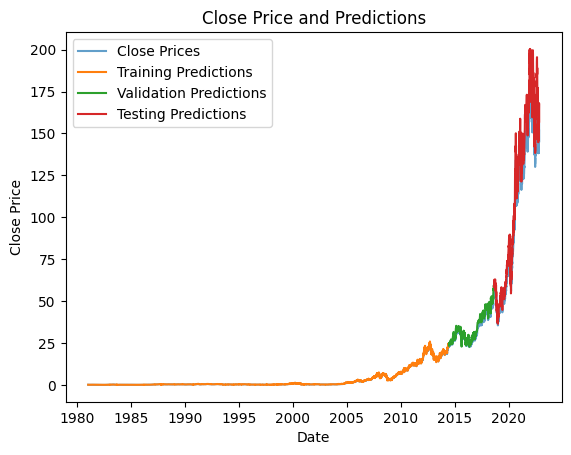

In [71]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [72]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aapl_scores["lr"] = results

Train Score: 0.63 RMSE
Cross Validation Score: 2.87 RMSE
Test Score: 15.12 RMSE


### Random Forest Regressor

#### Training

In [73]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [74]:
train_pred = rf.predict(X_train).flatten()
val_pred = rf.predict(X_val).flatten()
test_pred = rf.predict(X_test).flatten()

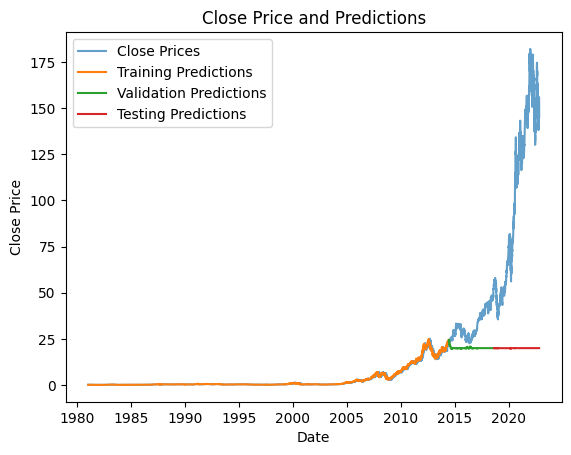

In [75]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [76]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aapl_scores["rf"] = results

Train Score: 0.13 RMSE
Cross Validation Score: 15.94 RMSE
Test Score: 97.73 RMSE


### Support Vector Machine

#### Training

In [77]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [78]:
svm = SVR(kernel="linear", C=1)
svm.fit(X_train_scaled, y_train)

SVR(C=1, kernel='linear')

#### Results

In [79]:
train_pred = svm.predict(X_train_scaled).flatten()
val_pred = svm.predict(X_val_scaled).flatten()
test_pred = svm.predict(X_test_scaled).flatten()

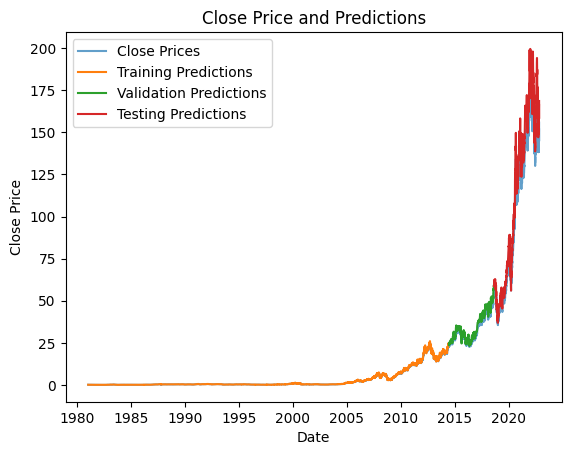

In [80]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [81]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aapl_scores["svm"] = results

Train Score: 0.63 RMSE
Cross Validation Score: 2.86 RMSE
Test Score: 15.03 RMSE


### LSTM

#### Training

In [82]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1981-01-29,0.143973,0.142857,0.138393,0.133371
1,1981-01-30,0.142857,0.138393,0.133371,0.126116
2,1981-02-02,0.138393,0.133371,0.126116,0.118862
3,1981-02-03,0.133371,0.126116,0.118862,0.123326
4,1981-02-04,0.126116,0.118862,0.123326,0.127790
...,...,...,...,...,...
10523,2022-10-24,143.860001,143.389999,147.270004,149.449997
10524,2022-10-25,143.389999,147.270004,149.449997,152.339996
10525,2022-10-26,147.270004,149.449997,152.339996,149.350006
10526,2022-10-27,149.449997,152.339996,149.350006,144.800003


In [83]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
# dates.shape, X.shape, y.shape
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [84]:
dates_train = dates[: len(X_train)]
dates_val = dates[len(X_train) : len(X_train) + len(X_val)]
dates_test = dates[len(X_train) + len(X_val) :]

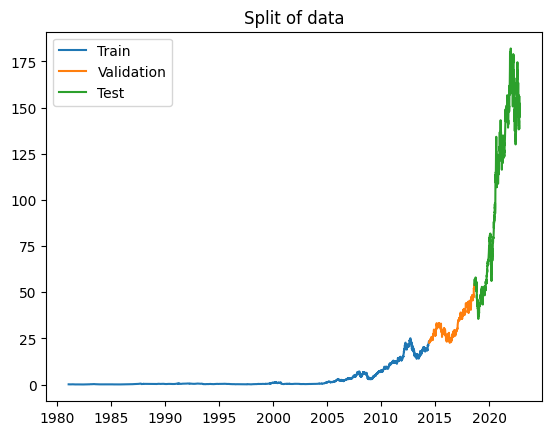

In [85]:
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test")
plt.title("Split of data")
plt.legend()

In [86]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
264/264 [==============================] - 2s 4ms/step - loss: 3.3699 - mean_absolute_error: 0.5050 - val_loss: 97.7461 - val_mean_absolute_error: 7.1905
Epoch 2/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0225 - mean_absolute_error: 0.0619 - val_loss: 82.1462 - val_mean_absolute_error: 6.3319
Epoch 3/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0545 - val_loss: 77.6467 - val_mean_absolute_error: 6.2608
Epoch 4/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0602 - val_loss: 72.0440 - val_mean_absolute_error: 5.7975
Epoch 5/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0187 - mean_absolute_error: 0.0567 - val_loss: 70.8199 - val_mean_absolute_error: 5.8353
Epoch 6/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0213 - mean_absolute_error: 0.0591 - val_loss: 70.6592 - val_mean_absolute_error: 5.9360
Epoc

#### Results

33/33 [==============================] - 0s 647us/step


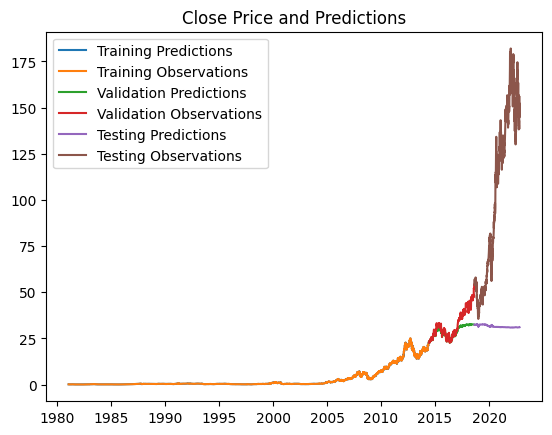

In [87]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")

# validation data
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")

# testing data
plt.plot(dates_test, test_pred, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")

plt.title("Close Price and Predictions")
plt.legend()
plt.show()

In [88]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
aapl_scores["lstm"] = results

Train Score: 0.11 RMSE
Cross Validation Score: 6.31 RMSE
Test Score: 85.89 RMSE


In [89]:
aapl_scores

{'lr': [0.6302664698681203, 2.8701005913802065, 15.116967602062342],
 'rf': [0.13039188096147478, 15.942627949095257, 97.72588815000849],
 'svm': [0.6346197122522353, 2.856240405025201, 15.027856740552417],
 'lstm': [0.11243739, 6.306493, 85.88628]}

## Microsoft Dataframe

In [90]:
df = load_data("MSFT")

In [91]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1986-04-24,0.099826,0.100260,62352000,0.111979,0.110243,0.069860,0.118924,0.098249
1986-04-25,0.111111,0.111111,85795200,0.121962,0.117188,0.074261,0.113715,0.098915
1986-04-28,0.116319,0.117188,28886400,0.118924,0.118056,0.074811,0.113715,0.099494
1986-04-29,0.113715,0.118056,30326400,0.118056,0.114583,0.072610,0.113715,0.099899
1986-04-30,0.109375,0.114583,30902400,0.115451,0.111979,0.070960,0.109375,0.100304
...,...,...,...,...,...,...,...,...
2022-10-24,241.300003,243.759995,24911200,247.839996,247.250000,247.250000,245.119995,239.519000
2022-10-25,245.830002,247.259995,34775500,251.039993,250.660004,250.660004,244.369995,239.474667
2022-10-26,230.059998,231.169998,82543200,238.300003,231.320007,231.320007,247.399994,238.778000


Text(0.5, 1.0, 'Close Prices Over Time')

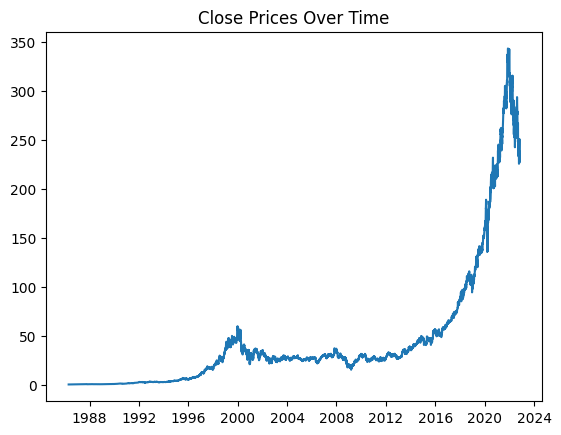

In [92]:
plt.plot(df.index, df['Close'])
plt.title("Close Prices Over Time")

In [93]:
X = df.drop(columns="Label")
y = df["Label"]

In [94]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Linear Regression

#### Training

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [96]:
train_pred = lr.predict(X_train).flatten()
val_pred = lr.predict(X_val).flatten()
test_pred = lr.predict(X_test).flatten()

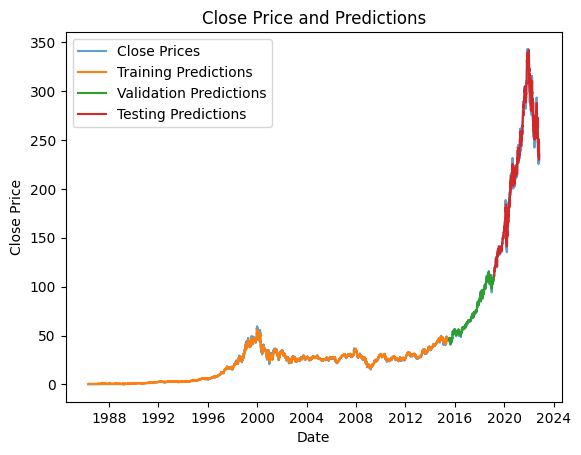

In [97]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [98]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
msft_scores["lr"] = results

Train Score: 2.51 RMSE
Cross Validation Score: 4.61 RMSE
Test Score: 19.18 RMSE


### Random Forest Regressor

#### Training

In [99]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [100]:
train_pred = rf.predict(X_train).flatten()
val_pred = rf.predict(X_val).flatten()
test_pred = rf.predict(X_test).flatten()

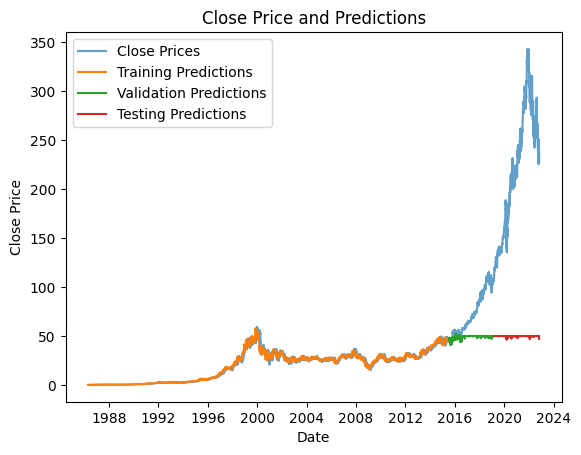

In [101]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [102]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
msft_scores["rf"] = results

Train Score: 0.61 RMSE
Cross Validation Score: 34.69 RMSE
Test Score: 185.43 RMSE


### Support Vector Machine

#### Training

In [103]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [104]:
svm = SVR(kernel="linear", C=1)
svm.fit(X_train_scaled, y_train)

SVR(C=1, kernel='linear')

#### Results

In [105]:
train_pred = svm.predict(X_train_scaled).flatten()
val_pred = svm.predict(X_val_scaled).flatten()
test_pred = svm.predict(X_test_scaled).flatten()

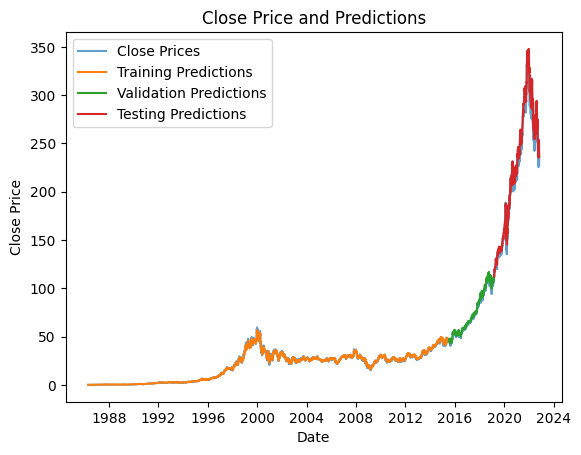

In [106]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [107]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
msft_scores["svm"] = results

Train Score: 2.53 RMSE
Cross Validation Score: 4.27 RMSE
Test Score: 19.25 RMSE


### LSTM

#### Training

In [108]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-04-29,0.110243,0.117188,0.118056,0.114583
1,1986-04-30,0.117188,0.118056,0.114583,0.111979
2,1986-05-01,0.118056,0.114583,0.111979,0.110243
3,1986-05-02,0.114583,0.111979,0.110243,0.110243
4,1986-05-05,0.111979,0.110243,0.110243,0.109375
...,...,...,...,...,...
9197,2022-10-24,236.479996,236.149994,242.119995,247.250000
9198,2022-10-25,236.149994,242.119995,247.250000,250.660004
9199,2022-10-26,242.119995,247.250000,250.660004,231.320007
9200,2022-10-27,247.250000,250.660004,231.320007,226.750000


In [109]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
# dates.shape, X.shape, y.shape
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [110]:
dates_train = dates[: len(X_train)]
dates_val = dates[len(X_train) : len(X_train) + len(X_val)]
dates_test = dates[len(X_train) + len(X_val) :]

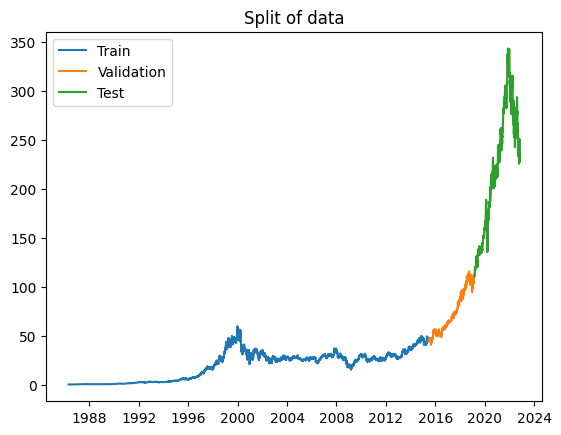

In [111]:
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test")
plt.title("Split of data")
plt.legend()

In [112]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
231/231 [==============================] - 2s 4ms/step - loss: 120.6377 - mean_absolute_error: 5.1165 - val_loss: 1039.2347 - val_mean_absolute_error: 24.0961
Epoch 2/100
231/231 [==============================] - 1s 2ms/step - loss: 0.3812 - mean_absolute_error: 0.3432 - val_loss: 855.4550 - val_mean_absolute_error: 20.9276
Epoch 3/100
231/231 [==============================] - 1s 3ms/step - loss: 0.3407 - mean_absolute_error: 0.3392 - val_loss: 788.1953 - val_mean_absolute_error: 19.7368
Epoch 4/100
231/231 [==============================] - 1s 2ms/step - loss: 0.3277 - mean_absolute_error: 0.3273 - val_loss: 730.7249 - val_mean_absolute_error: 18.6652
Epoch 5/100
231/231 [==============================] - 1s 2ms/step - loss: 0.3721 - mean_absolute_error: 0.3610 - val_loss: 707.8597 - val_mean_absolute_error: 18.3931
Epoch 6/100
231/231 [==============================] - 1s 3ms/step - loss: 0.3425 - mean_absolute_error: 0.3479 - val_loss: 697.8210 - val_mean_absolute_erro

#### Results

29/29 [==============================] - 0s 666us/step


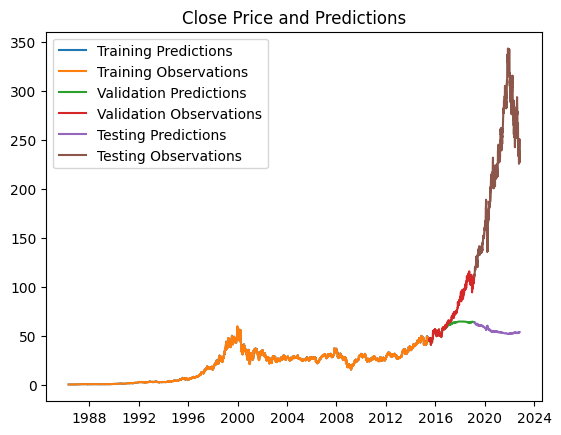

In [113]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")

# validation data
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")

# testing data
plt.plot(dates_test, test_pred, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")

plt.title("Close Price and Predictions")
plt.legend()
plt.show()

In [114]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
msft_scores["lstm"] = results

Train Score: 0.51 RMSE
Cross Validation Score: 22.67 RMSE
Test Score: 178.72 RMSE


In [115]:
msft_scores

{'lr': [2.5105129284816807, 4.605999196259504, 19.17503122716343],
 'rf': [0.6059539357774826, 34.68924531402895, 185.43199639607454],
 'svm': [2.5299954247479843, 4.265567956528273, 19.25184240271443],
 'lstm': [0.5085656, 22.672354, 178.71565]}

## Nvidia Dataframe

In [116]:
df = load_data("NVDA")

In [117]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1999-03-05,0.419271,0.419271,7876800,0.440104,0.438802,0.403209,0.395833,0.423785
1999-03-08,0.419271,0.427083,7588800,0.458333,0.445313,0.409191,0.388021,0.424957
1999-03-09,0.444010,0.444010,14318400,0.466146,0.459635,0.422352,0.394531,0.425174
1999-03-10,0.445313,0.466146,23534400,0.466146,0.451823,0.415173,0.377604,0.426302
1999-03-11,0.432292,0.444010,5428800,0.451823,0.432292,0.397227,0.359375,0.426823
...,...,...,...,...,...,...,...,...
2022-10-24,120.639999,125.080002,51745700,127.099998,125.989998,125.989998,159.869995,124.739999
2022-10-25,126.639999,126.940002,50548200,133.000000,132.610001,132.610001,161.199997,124.783333
2022-10-26,127.080002,128.690002,53295300,133.880005,128.960007,128.960007,171.690002,124.706000


Text(0.5, 1.0, 'Close Prices Over Time')

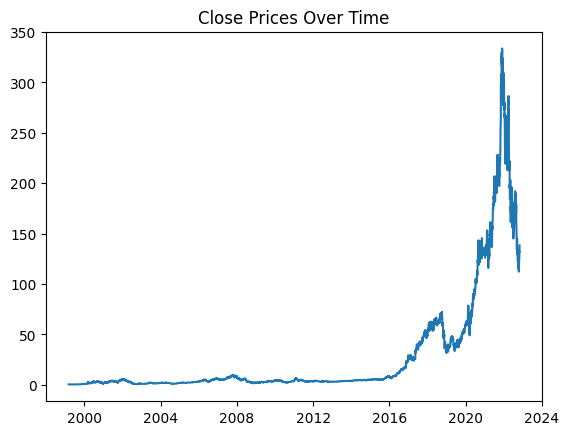

In [118]:
plt.plot(df.index, df['Close'])
plt.title("Close Prices Over Time")

In [119]:
X = df.drop(columns="Label")
y = df["Label"]

In [120]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Linear Regression

#### Training

In [121]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [122]:
train_pred = lr.predict(X_train).flatten()
val_pred = lr.predict(X_val).flatten()
test_pred = lr.predict(X_test).flatten()

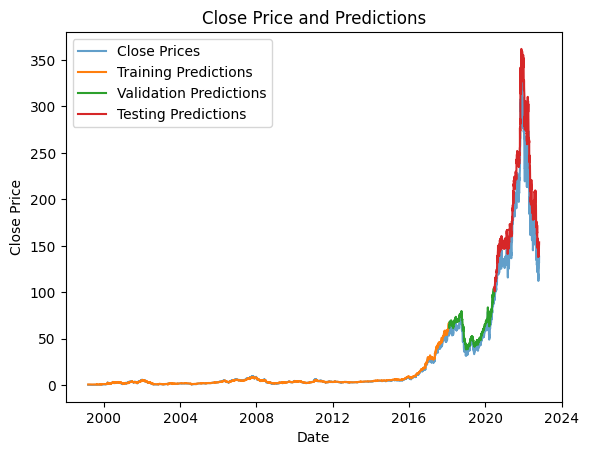

In [123]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [124]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
nvda_scores["lr"] = results

Train Score: 1.33 RMSE
Cross Validation Score: 10.72 RMSE
Test Score: 46.11 RMSE


### Random Forest Regressor

#### Training

In [125]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [126]:
train_pred = rf.predict(X_train).flatten()
val_pred = rf.predict(X_val).flatten()
test_pred = rf.predict(X_test).flatten()

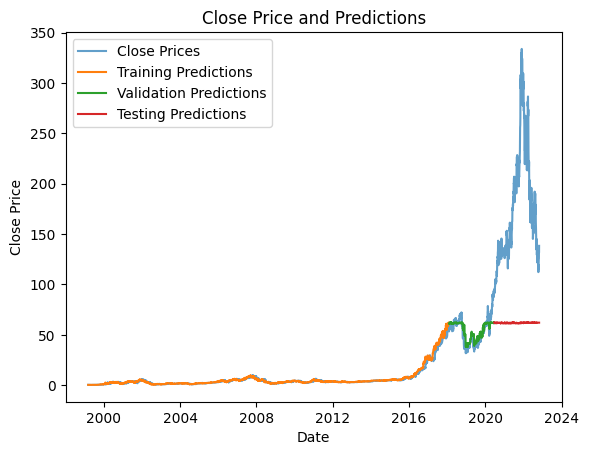

In [127]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [128]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
nvda_scores["rf"] = results

Train Score: 0.27 RMSE
Cross Validation Score: 13.19 RMSE
Test Score: 130.20 RMSE


### Support Vector Machine

#### Training

In [129]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [130]:
svm = SVR(kernel="linear", C=1)
svm.fit(X_train_scaled, y_train)

SVR(C=1, kernel='linear')

#### Results

In [131]:
train_pred = svm.predict(X_train_scaled).flatten()
val_pred = svm.predict(X_val_scaled).flatten()
test_pred = svm.predict(X_test_scaled).flatten()

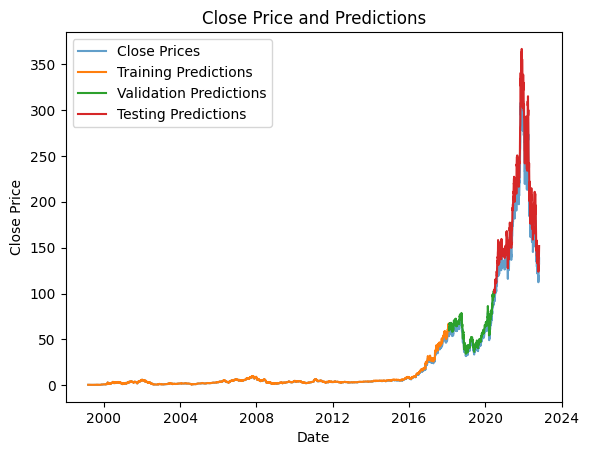

In [132]:
sorted_dates = df.index.sort_values()
sorted_close_prices = df.loc[sorted_dates, "Close"]

dates_train = sorted_dates[: len(train_pred)]
dates_val = sorted_dates[len(train_pred) : len(train_pred) + len(val_pred)]
dates_test = sorted_dates[len(train_pred) + len(val_pred) :]

# Plot the close prices
plt.plot(sorted_dates, sorted_close_prices, label="Close Prices", alpha=0.7)
# Plot the predictions
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_test, test_pred, label="Testing Predictions")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price and Predictions")
plt.legend()

In [133]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print("Cross Validation Score: %.2f RMSE" % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
nvda_scores["svm"] = results

Train Score: 1.40 RMSE
Cross Validation Score: 9.66 RMSE
Test Score: 41.12 RMSE


### LSTM

#### Training

In [134]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1999-03-10,0.438802,0.445313,0.459635,0.451823
1,1999-03-11,0.445313,0.459635,0.451823,0.432292
2,1999-03-12,0.459635,0.451823,0.432292,0.424479
3,1999-03-15,0.451823,0.432292,0.424479,0.442708
4,1999-03-16,0.432292,0.424479,0.442708,0.428385
...,...,...,...,...,...
5946,2022-10-24,120.510002,121.940002,124.660004,125.989998
5947,2022-10-25,121.940002,124.660004,125.989998,132.610001
5948,2022-10-26,124.660004,125.989998,132.610001,128.960007
5949,2022-10-27,125.989998,132.610001,128.960007,131.759995


In [135]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
# dates.shape, X.shape, y.shape
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [136]:
dates_train = dates[: len(X_train)]
dates_val = dates[len(X_train) : len(X_train) + len(X_val)]
dates_test = dates[len(X_train) + len(X_val) :]

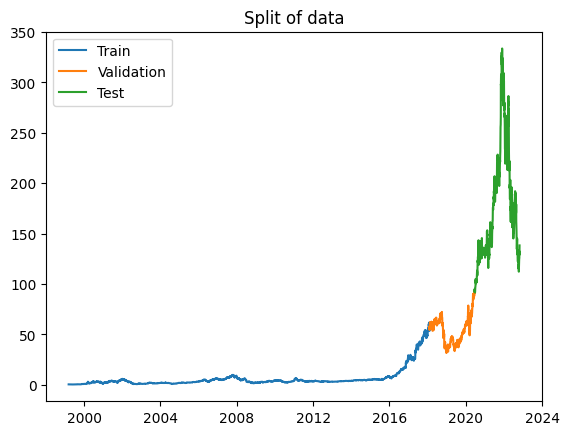

In [137]:
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test")
plt.title("Split of data")
plt.legend()

In [138]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
149/149 [==============================] - 2s 4ms/step - loss: 46.4555 - mean_absolute_error: 2.3881 - val_loss: 225.5884 - val_mean_absolute_error: 11.1044
Epoch 2/100
149/149 [==============================] - 0s 2ms/step - loss: 0.4375 - mean_absolute_error: 0.2352 - val_loss: 85.2039 - val_mean_absolute_error: 5.6890
Epoch 3/100
149/149 [==============================] - 0s 3ms/step - loss: 0.2091 - mean_absolute_error: 0.2113 - val_loss: 65.7329 - val_mean_absolute_error: 4.8292
Epoch 4/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1590 - mean_absolute_error: 0.1915 - val_loss: 54.4524 - val_mean_absolute_error: 4.1233
Epoch 5/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1484 - mean_absolute_error: 0.1802 - val_loss: 48.6620 - val_mean_absolute_error: 3.8444
Epoch 6/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1302 - mean_absolute_error: 0.1654 - val_loss: 46.2254 - val_mean_absolute_error: 3.7186
E

#### Results

19/19 [==============================] - 0s 693us/step


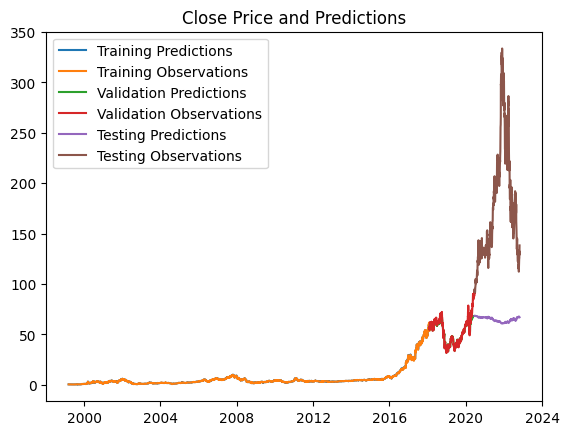

In [139]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")

# validation data
plt.plot(dates_val, val_pred, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")

# testing data
plt.plot(dates_test, test_pred, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")

plt.title("Close Price and Predictions")
plt.legend()
plt.show()

In [140]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

# create a list of scores
results = [trainScore, valScore, testScore]
# add the list to the dictionary
nvda_scores["lstm"] = results

Train Score: 0.30 RMSE
Cross Validation Score: 4.98 RMSE
Test Score: 126.98 RMSE


In [141]:
nvda_scores

{'lr': [1.3327301757726084, 10.718367156327849, 46.10805975138696],
 'rf': [0.2737218436403303, 13.193325354023012, 130.19702361257748],
 'svm': [1.404568729465289, 9.662977390332188, 41.122432649179125],
 'lstm': [0.2950128, 4.9841666, 126.97824]}

# Conclusion

In [142]:
print(f"Amazon Results: {amzn_scores}")
print(f"American Airlines Results: {aal_scores}")
print(f"Apple Results: {aapl_scores}")
print(f"Microsoft Results: {msft_scores}")
print(f"Nvidia Results: {nvda_scores}")

Amazon Results: {'lr': [1.3066756330659544, 8.684258042986047, 18.049148749123855], 'rf': [0.2552041960579979, 40.3270890912664, 103.06557299434472], 'svm': [1.3087238552888387, 8.655824310240376, 18.28902523482942], 'lstm': [0.27149323, 28.868366, 97.71498]}
American Airlines Results: {'lr': [4.311301040256385, 7.418295691383942, 3.7072570042613617], 'rf': [1.1022086096343575, 6.7661975348862065, 4.064471815714501], 'svm': [4.327837289950504, 7.245699450135821, 3.7633889981402477], 'lstm': [0.9225317, 0.81813926, 0.6110661]}
Apple Results: {'lr': [0.6302664698681203, 2.8701005913802065, 15.116967602062342], 'rf': [0.13039188096147478, 15.942627949095257, 97.72588815000849], 'svm': [0.6346197122522353, 2.856240405025201, 15.027856740552417], 'lstm': [0.11243739, 6.306493, 85.88628]}
Microsoft Results: {'lr': [2.5105129284816807, 4.605999196259504, 19.17503122716343], 'rf': [0.6059539357774826, 34.68924531402895, 185.43199639607454], 'svm': [2.5299954247479843, 4.265567956528273, 19.251

In [143]:
stocks = {
    'Amazon': amzn_scores,
    'American Airlines': aal_scores,
    'Apple': aapl_scores,
    'Microsoft': msft_scores,
    'Nvidia': nvda_scores,
}

In [144]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Company', 'Model', 'Train RMSE', 'Validation RMSE', 'Test RMSE'])

# Fill the DataFrame
for company, scores in stocks.items():
    for model, rmse_values in scores.items():
        full_model = model.upper()
        if model == "lr":
            full_model = "Linear Reg"
        if model == "rf":
            full_model = "Random Forest"
        
        new_row = pd.DataFrame({
            'Company': [company],
            'Model': [full_model],
            'Train RMSE': [f"{rmse_values[0]:.2f}"],
            'Validation RMSE': [f"{rmse_values[1]:.2f}"],
            'Test RMSE': [f"{rmse_values[2]:.2f}"],
        })
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Set index
results_df.set_index(['Company', 'Model'], inplace=True)

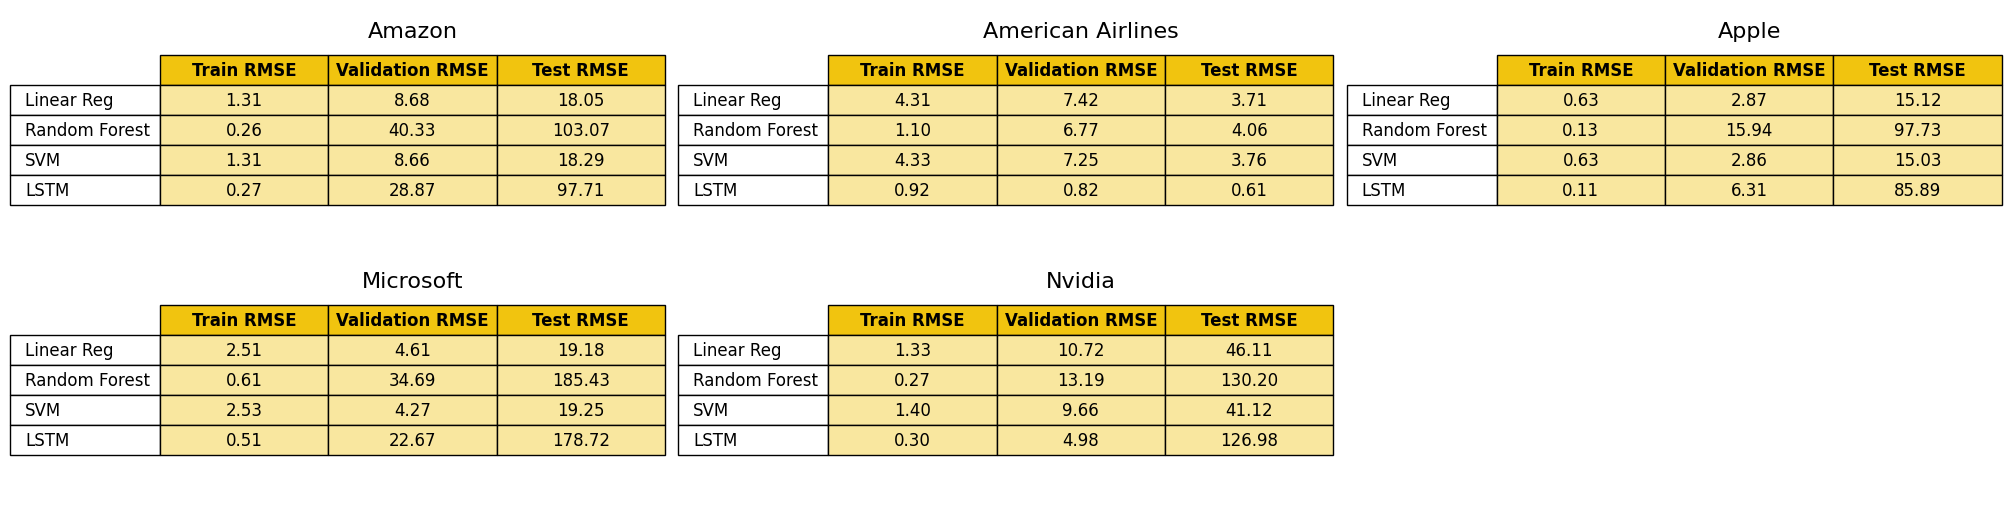

In [168]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5), constrained_layout=True)
axes = axes.flatten()

# Remove the last (empty) subplot
fig.delaxes(axes[-1])

# Create tables for each stock
for ax, (company, scores) in zip(axes, stocks.items()):
    # Filter results for the current company
    company_results = results_df.loc[company]
    
    ax.axis('off')
    ax.set_title(company, fontsize=16, y=0.85)  # Adjust the y parameter to move the title closer to the table
    table = ax.table(cellText=company_results.values, colLabels=company_results.columns, rowLabels=company_results.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.3)

    # Set table colors
    for i in range(len(company_results.index) + 1):
        for j in range(len(company_results.columns) + 1):
            if (i, j) not in table.get_celld():
                continue
            cell = table[i, j]
            if i == 0:
                cell.set_facecolor('#f1c40f')  # Change the column headers color
                cell.get_text().set_weight('bold')
            else:
                cell.set_facecolor('#f9e79f')  # Change the cell color

plt.show()